Author: Prakrut Kansara, Kris Su

Description:

Date created: 
(photo credit: PK)

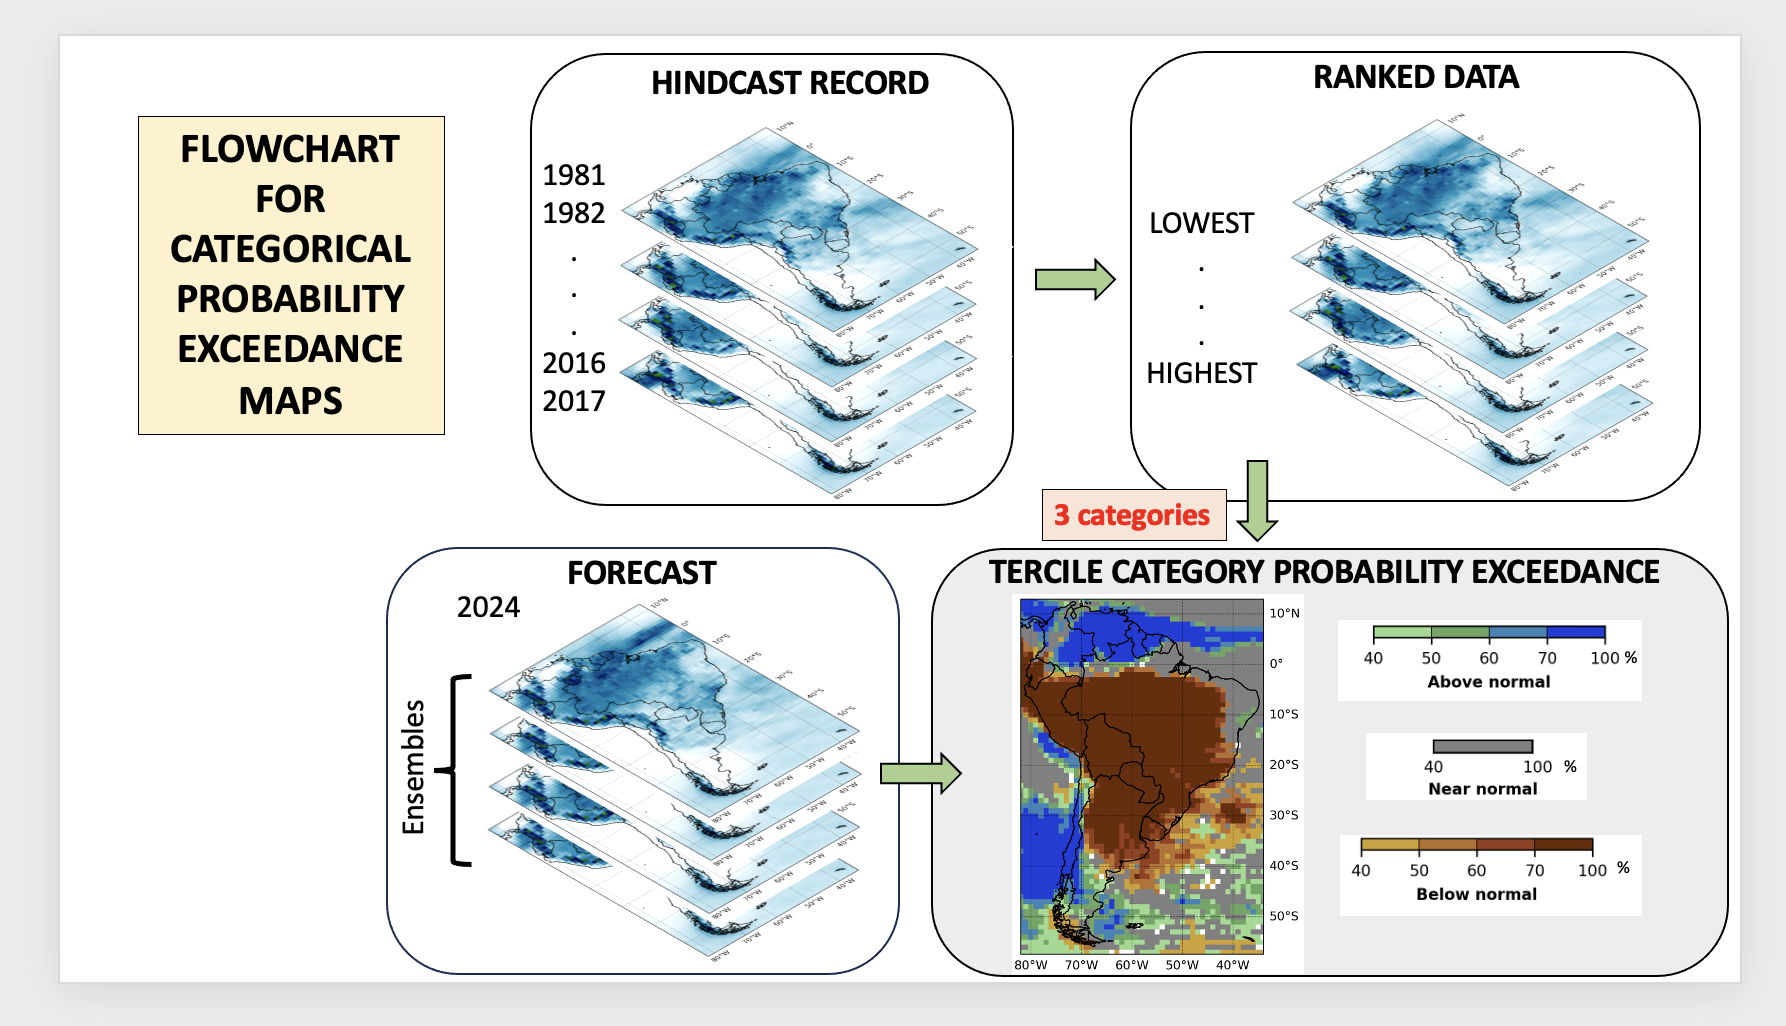
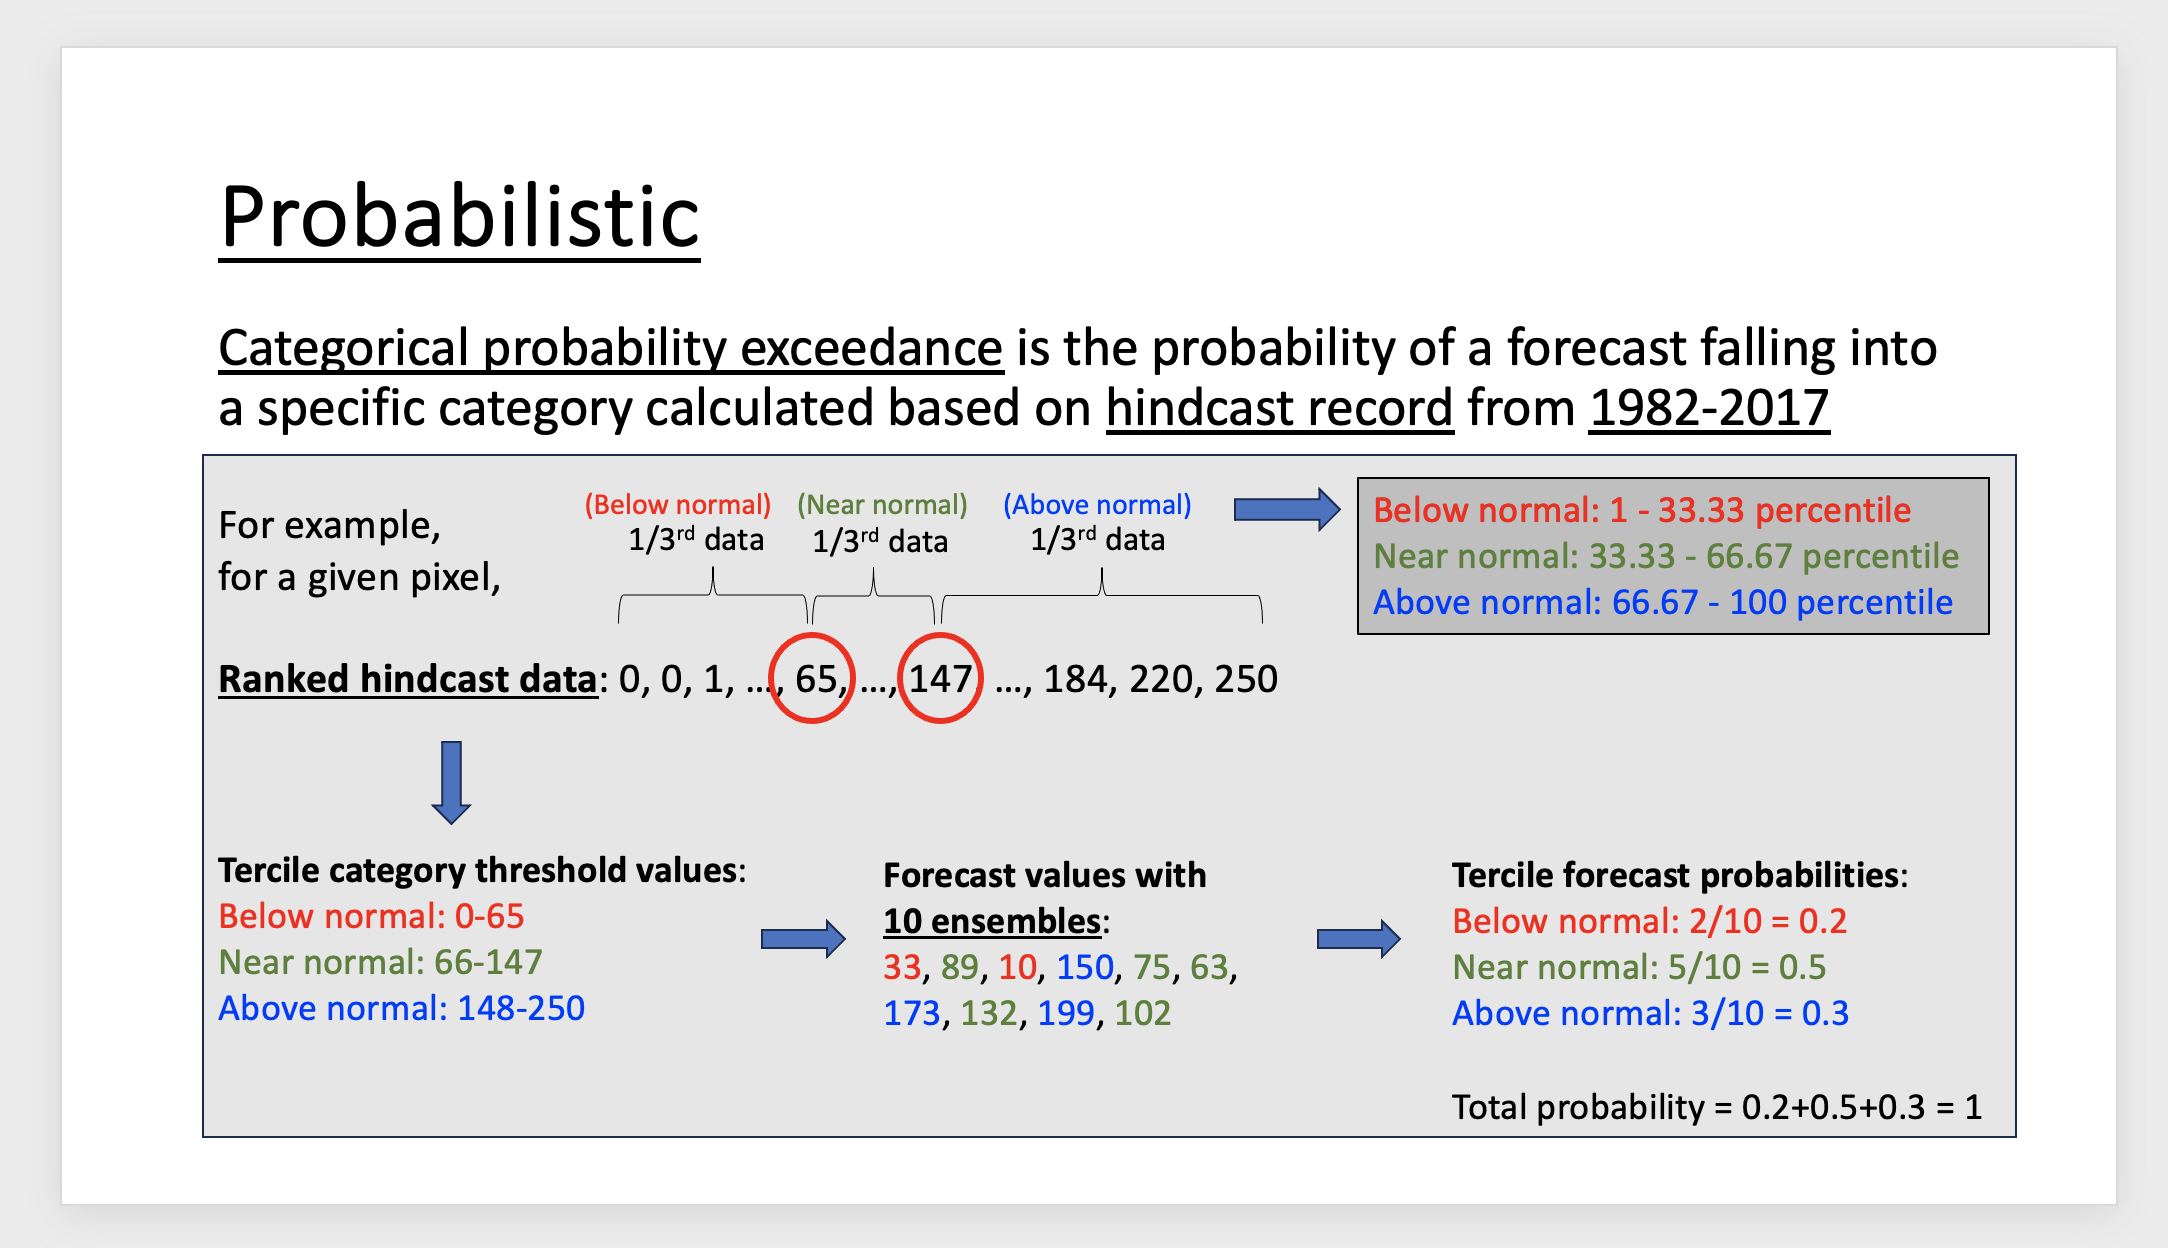

In [2]:
import xarray as xr 
import pandas as pd
import numpy as np
import os

forecast in the past will be hindcast,

few changes for the code, 

he only things will change is the time step: for each month in Jan 2023 up to october of 2024 hindcast going 6 months into the future. 

Servir project, and the dashboard, incorporate LDAS into 

In [4]:
os.getcwd()

'/Users/kris/amazonforcast/github/spring_2024_envs_research/python/ensemble'

In [7]:
## Global variables
surface_variable_short = ['Rainf_tavg', 'Qair_f_tavg',
                          'Qs_tavg','Evap_tavg',
                          'SoilMoist_inst', 'SoilTemp_inst']

surface_variable_long = ['precipitation rate', 'specific humidity', 'surface runoff',
                         'total evapotranspiration', 'soil moisture content', 'SoilTemp inst']

surface_variable_unit = {'Rainf_tavg':'mm/day', 'Qair_f_tavg':'g/kg', 'Qs_tavg':'', 
                         'Evap_tavg':'mm/day', 'SoilMoist_inst':'m^3 m-3', 'SoilTemp_inst':'degree Celsius'}

In [18]:
## Function to read and save forecast data ##
## Create function to read data and save it in RAM as xarray Dataset
def read_trim_forecast(file_path, va):
    """
    Args:
        file_path (str): directory of 
        list (list): list of variables that we will keep

    Return:
        forecast_data (xarray.core.dataset.Dataset): trimmed dataset
    """
    forecast_data = xr.open_dataset(file_path)[va]

    return forecast_data

In [ ]:
## Function to read and save hindcast data ##
## Create function to read data and save it as netcdf file ##
def read_hindcast(model, va):

    ## Subset the data to the South America domain ##
    data_south_america = remote_data.sel(X=slice(bounds[0],bounds[1]),Y=slice(bounds[2],bounds[3]))
    data_south_america = data_south_america.transpose('S','L','M','Y','X')

    ## Function to convert the 'months since' epoch to datetime ## 
    def convert_timestamp_to_datetime(x):
        return pd.Timestamp('1960-01-01') + pd.DateOffset(months=x)
        
    time_list = list(map(convert_timestamp_to_datetime, remote_data.S.values))

    ## Add the datetime indices as dimension and coordinates to create a new dataarray ##
    hindcast_data = xr.Dataset(data_vars = {va:(['time','L','M','Y','X'],data_south_america.values)}, coords=dict(time=time_list, L=data_south_america.L.values, M=data_south_america.M.values, Y=data_south_america.Y.values, X=data_south_america.X.values), attrs=data_south_america.attrs)

    output_savepath = output_directory + 'hindcast/'
    create_directory(output_savepath)
    hindcast_data.to_netcdf(output_savepath + 'hindcast_nmme_' + model.replace('-','_').lower() + '_' + va + '.nc')

    print('NMME hindcast data for ' + model + ' for ' + va + ' saved!')

    return hindcast_data

In [ ]:
## Function to calculate threshold for forecast categories defined by quantiles
def get_thresh(icat, quantiles, xrds, dims=['ensemble','time']):
    """
    Args:
        icat (int): the ith category, for looping through three categories
        quantiles (list): pre-defined boundaries for ranking
        xrds (xarray.core.dataset.Dataset): xarray dataset of forecast 
        dims (list): get thresh for each variables for 
    
    Returns:
        xrds_lo (xarray.core.dataset.Dataset): lower threshold 
        xrds_hi (xarray.core.dataset.Dataset): higher threshold 
    """
    if not all(elem in xrds.dims for elem in dims): 
        raise Exception('Some of the dimensions in {} is not present in the xr.Dataset {}'.format(dims,xrds))
    
    else:
        if icat == 0: # category 0
            xrds_lo = -np.inf
            xrds_hi = xrds.quantile(quantiles[icat],dim=dims)
        elif icat == len(quantiles): # category MAX
            xrds_lo = xrds.quantile(quantiles[icat-1],dim=dims) 
            xrds_hi = np.inf # the upper bound extent to positive infinite
        else:
            xrds_lo = xrds.quantile(quantiles[icat-1],dim=dims)
            xrds_hi = xrds.quantile(quantiles[icat],dim=dims)
    
    return xrds_lo, xrds_hi

In [1]:
## Function to calculate probabilities for tercile categories by counting members within each category
def calculate_probabilities(hcst, fcst, quantiles = [1/3., 2/3.]):
    """
    Args:
        hcst (xarray.core.dataset.Dataset):
        fcst (xarray.core.dataset.Dataset):
        quantiles (list): pre-defined boundaries for ranking

    Returns:
        probs (xarray.core.dataset.Dataset): 

    """
    print('Computing probabilities...')
    numcategories = len(quantiles)+1 # there are 3 categories in total 

    l_probs=list() # initialize empty list
    for icat in range(numcategories): # for each category
        print(f'category={icat}')
        h_lo, h_hi = get_thresh(icat, quantiles, hcst)
        prob = np.logical_and(fcst>h_lo, fcst<=h_hi).sum('M')/float(fcst.dims['M'])
        # Instead of using the coordinate 'quantile' coming from the hindcast xr.Dataset
        # we will create a new coordinate called 'category'
        if 'quantile' in prob:
            prob = prob.drop('quantile')
        l_probs.append(prob.assign_coords({'category':icat}))

    probs = xr.concat(l_probs,dim='category')
    # print(f'Saving {aggr} tercile probs netCDF files')
    # probs.to_netcdf(f'{DATADIR}/{hcst_bname}.{aggr}.tercile_probs.nc')

    return probs

In [ ]:
## Function to calculate two-category probabilities for CEMADEN ##
## Only save the data for above normal category air temperature and below normal precipitation ##
def calculate_two_ways_probabilities(hindcast,forecast, model, variable, initialization_date):
    """
    """
    cemaden_probs = calculate_probabilities(hindcast, forecast, quantiles=[1/2.])*100

    if variable=='prec':
        cemaden_probability = xr.Dataset(data_vars = {'below_normal':(['L','Y','X'],cemaden_probs.sel(category=0)[variable].data)}, 
                                            coords=dict(L=forecast.L.values,Y=forecast.Y.values, X=forecast.X.values), 
                                            attrs=forecast.attrs)
    elif variable=='tref':
        cemaden_probability = xr.Dataset(data_vars = {'above_normal':(['L','Y','X'],cemaden_probs.sel(category=1)[variable].data)}, 
                                            coords=dict(L=forecast.L.values,Y=forecast.Y.values, X=forecast.X.values), 
                                            attrs=forecast.attrs)
        
    ## Save the forecast data to a netcdf file ##
    year = forecast.time.dt.year.values
    month = forecast.time.dt.month.values
    day = forecast.time.dt.day.values

    cemaden_probability.to_netcdf(output_directory + initialization_date.replace('-','_') + '/cemaden_two_probability_' + model + '_' + variable + '_' + str(year) + '_' + str(month).zfill(2) + '_' + str(day).zfill(2) + '.nc')

    print('CEMADEN: Two probability categories calculated and saved for NMME hindcast data for ' + model + ' for ' + variable + '!')

## Data processing

In [24]:
for variables in surface_variable_short:
    print(variables)
    hindcast = 
    forecast  = read_trim_forecast(file_path='',va=variables)


Rainf_tavg
Qair_f_tavg
Qs_tavg
Evap_tavg
SoilMoist_inst
SoilTemp_inst
